In [198]:
# Import relevant libraries
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
from matplotlib import colors
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning, PolicyIterationModified
import random
from timeit import default_timer as timer
from datetime import timedelta
import time
import copy
from hiive.mdptoolbox.example import forest
# Set the random seed
np.random.seed(42)

In [347]:
T, R = forest(S=25)

In [200]:
colors = {
    0: 'g',
    1: 'k'
}

labels = {
    0: 'W',
    1: 'C',
}

def plot_forest(policy, title='Forest Management'):
    rows = 5
    cols = 5
    
    policy = np.array(list(policy)).reshape(rows,cols)
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim = (-.01, rows+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    
    for i in range(rows):
        for j in range(cols):
            y = rows - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            text = ax.text(x+0.5, y+0.5, labels[policy[i, j]],
                           horizontalalignment='center', size=25, verticalalignment='center', color='w')
    
    plt.axis('off')
    
def evaluate_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  np.random.choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / test_count

In [328]:
def trainVI(P, R, discount=0.9, epsilon=[1e-9]):
    vi_df = pd.DataFrame(columns=["Epsilon", 'Discount', "Policy", "Iteration", 
                                  "Time", "Reward",
                                  "Value Function",
                                  #'Avg_Steps','Steps_StDev','Success_Rate'
                                 ])
    vi_run_full = pd.DataFrame()

    for gamma in discount:
        for eps in epsilon:
            vi = ValueIteration(P, R, gamma=gamma, epsilon=eps, max_iter=int(1e15))
            vi_run, vi_policy = vi.run()
            vi_run_df = pd.DataFrame(vi_run)
            vi_run_df['Eps'] = str(float(eps))
            vi_run_df['Gamma'] = str(float(gamma))

            reward = max(vi_run_df['Reward'])
            #steps, steps_stddev, failures = get_score(env, vi.policy, None)
            info = [float(eps),float(gamma), vi.policy, vi.iter, vi.time, reward,
                    vi.V,
                    #steps,steps_stddev,
                    # Success is 100% - failure%
                    #100-failures
                   ]
            df_length = len(vi_df)
            vi_df.loc[df_length] = info
                    
            vi_run_full = pd.concat([vi_run_full,vi_run_df])
            
    return vi_df, vi_policy, vi_run,vi,vi_run_full

In [348]:
%%time
discount= [0.5,0.75,0.9,0.99]
epsilon=[1e-3,1e-5,1e-7]

vi_df,vi_policy,vi_run,vi,vi_run_full = trainVI(T, R, discount= discount, epsilon=epsilon)
df = pd.DataFrame(vi_run)
vi_df

Wall time: 221 ms


,Epsilon,Discount,Policy,Iteration,Time,Reward,Value Function
0,1.000000e-03,0.50,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",11,0.002990,7.327719,"(0.6201770166571289, 1.3099378634365235, 1.309..."
1,1.000000e-05,0.50,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",17,0.001984,7.329138,"(0.6206820116693589, 1.3103380615783164, 1.310..."
2,1.000000e-07,0.50,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",22,0.000997,7.329153,"(0.6206894369721959, 1.3103445931937352, 1.310..."
3,1.000000e-03,0.75,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",24,0.000998,12.676914,"(1.6100617702605673, 2.207028912378045, 2.2070..."
4,1.000000e-05,0.75,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",36,0.001993,12.679611,"(1.6118802791103277, 2.2088947769983336, 2.208..."
5,1.000000e-07,0.75,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",48,0.001966,12.679677,"(1.6119383927092432, 2.2089533142579514, 2.208..."
6,1.000000e-03,0.90,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",50,0.003987,23.147532,"(4.45073245336777, 5.003203966407059, 5.003203..."
7,1.000000e-05,0.90,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",72,0.004982,23.170025,"(4.472734105234681, 5.025220150767571, 5.02522..."
8,1.000000e-07,0.90,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",94,0.005068,23.172197,"(4.474901375030976, 5.027387561496171, 5.02738..."
9,1.000000e-03,0.99,"(0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",112,0.006978,64.123878,"(31.749455165201972, 32.27827460787745, 32.278..."


In [349]:
vi_df_05_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.5']))]
vi_df_05_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.5']))]
vi_df_05_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.5']))]

vi_df_075_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.75']))]
vi_df_075_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.75']))]
vi_df_075_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.75']))]

vi_df_09_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.9']))]
vi_df_09_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.9']))]
vi_df_09_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.9']))]

vi_df_099_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.99']))]
vi_df_099_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.99']))]
vi_df_099_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.99']))]

In [346]:
vi_run_full

,State,Action,Reward,Error,Time,Max V,Mean V,Iteration,Eps,Gamma
0,None,None,200.000000,2.000000e+02,0.000000,200.000000,8.920000,1,0.001,0.5
1,None,None,300.000000,1.000000e+02,0.000000,300.000000,16.900000,2,0.001,0.5
2,None,None,350.000000,5.000000e+01,0.000000,350.000000,23.070000,3,0.001,0.5
3,None,None,375.000000,2.500000e+01,0.001038,375.000000,27.025000,4,0.001,0.5
4,None,None,387.500000,1.250000e+01,0.001038,387.500000,29.522500,5,0.001,0.5
...,...,...,...,...,...,...,...,...,...,...
21,None,None,3967.388209,1.619456e+02,0.001010,3967.388209,1762.046671,22,1e-07,0.99
22,None,None,4127.714327,1.603261e+02,0.001010,4127.714327,1909.180032,23,1e-07,0.99
23,None,None,4286.437184,1.579292e+02,0.001010,4286.437184,2061.154922,24,1e-07,0.99
24,None,None,4443.572812,1.066224e+01,0.002095,4443.572812,2217.864060,25,1e-07,0.99


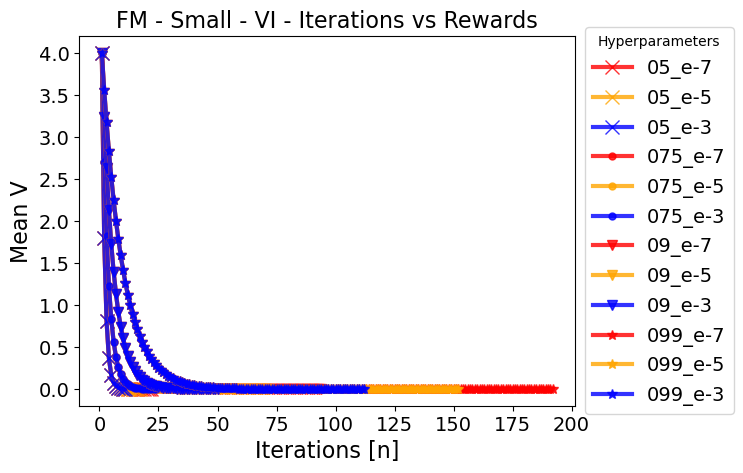

In [350]:
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')
plt.plot(vi_df_05_e5['Iteration'],vi_df_05_e5['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5')
plt.plot(vi_df_05_e3['Iteration'],vi_df_05_e3['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3')

plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7')
plt.plot(vi_df_075_e5['Iteration'],vi_df_075_e5['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5')
plt.plot(vi_df_075_e3['Iteration'],vi_df_075_e3['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3')

plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Error'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='09_e-7')
plt.plot(vi_df_09_e5['Iteration'],vi_df_09_e5['Error'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5')
plt.plot(vi_df_09_e3['Iteration'],vi_df_09_e3['Error'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='09_e-3')

plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Error'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='099_e-7')
plt.plot(vi_df_099_e5['Iteration'],vi_df_099_e5['Error'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5')
plt.plot(vi_df_099_e3['Iteration'],vi_df_099_e3['Error'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='099_e-3')


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FM - Small - VI - Iterations vs Rewards', size =16)
plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
#plt.xscale('log')

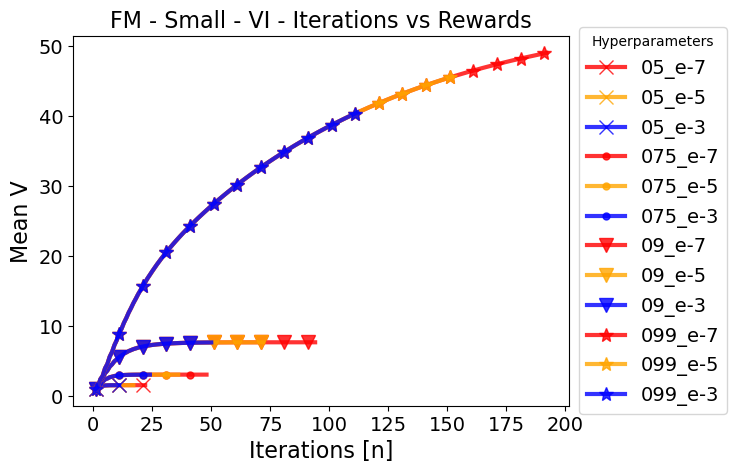

In [351]:
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7',markevery=10)
plt.plot(vi_df_05_e5['Iteration'],vi_df_05_e5['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5',markevery=10)
plt.plot(vi_df_05_e3['Iteration'],vi_df_05_e3['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3',markevery=10)

plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7',markevery=10)
plt.plot(vi_df_075_e5['Iteration'],vi_df_075_e5['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5',markevery=10)
plt.plot(vi_df_075_e3['Iteration'],vi_df_075_e3['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3',markevery=10)

plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Mean V'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='09_e-7',markevery=10)
plt.plot(vi_df_09_e5['Iteration'],vi_df_09_e5['Mean V'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5',markevery=10)
plt.plot(vi_df_09_e3['Iteration'],vi_df_09_e3['Mean V'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='09_e-3',markevery=10)

plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Mean V'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='099_e-7',markevery=10)
plt.plot(vi_df_099_e5['Iteration'],vi_df_099_e5['Mean V'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5',markevery=10)
plt.plot(vi_df_099_e3['Iteration'],vi_df_099_e3['Mean V'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='099_e-3',markevery=10)


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FM - Small - VI - Iterations vs Rewards', size =16)
plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})

Text(0.5, 1.0, 'FM - Small - VI - Iterations vs Rewards')

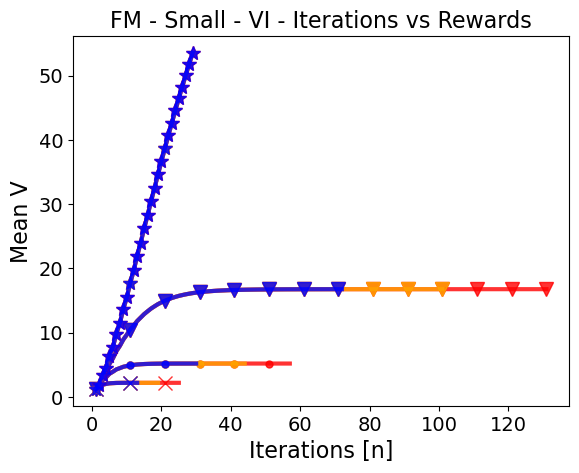

In [295]:
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7',markevery=10)
plt.plot(vi_df_05_e5['Iteration'],vi_df_05_e5['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5',markevery=10)
plt.plot(vi_df_05_e3['Iteration'],vi_df_05_e3['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3',markevery=10)

plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7',markevery=10)
plt.plot(vi_df_075_e5['Iteration'],vi_df_075_e5['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5',markevery=10)
plt.plot(vi_df_075_e3['Iteration'],vi_df_075_e3['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3',markevery=10)

plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Mean V'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='09_e-7',markevery=10)
plt.plot(vi_df_09_e5['Iteration'],vi_df_09_e5['Mean V'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5',markevery=10)
plt.plot(vi_df_09_e3['Iteration'],vi_df_09_e3['Mean V'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='09_e-3',markevery=10)

plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Mean V'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='099_e-7',markevery=1)
plt.plot(vi_df_099_e5['Iteration'],vi_df_099_e5['Mean V'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5',markevery=10)
plt.plot(vi_df_099_e3['Iteration'],vi_df_099_e3['Mean V'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='099_e-3',markevery=1)


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.xlim(190,193)
#plt.ylim(45,55)
plt.title('FM - Small - VI - Iterations vs Rewards', size =16)
#plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})

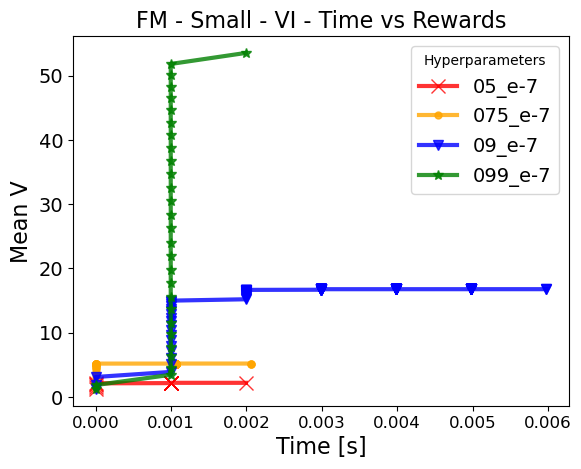

In [296]:
plt.plot(vi_df_05_e7['Time'],vi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')
#plt.plot(vi_df_05_e5['Time'],vi_df_05_e5['Reward'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'firebrick', label='05_e-5')
#plt.plot(vi_df_05_e3['Time'],vi_df_05_e3['Reward'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'lightcoral', label='05_e-3')

plt.plot(vi_df_075_e7['Time'],vi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7')
#plt.plot(vi_df_075_e5['Time'],vi_df_075_e5['Reward'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'bisque', label='075_e-5')
#plt.plot(vi_df_075_e3['Time'],vi_df_075_e3['Reward'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'peru', label='075_e-3')

plt.plot(vi_df_09_e7['Time'],vi_df_09_e7['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7')
#plt.plot(vi_df_09_e5['Time'],vi_df_09_e5['Reward'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'navy', label='09_e-5')
#plt.plot(vi_df_09_e3['Time'],vi_df_09_e3['Reward'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'cyan', label='09_e-3')

plt.plot(vi_df_099_e7['Time'],vi_df_099_e7['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7')
#plt.plot(vi_df_099_e5['Time'],vi_df_099_e5['Reward'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'lightgreen', label='099_e-5')
#plt.plot(vi_df_099_e3['Time'],vi_df_099_e3['Reward'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'lawngreen', label='099_e-3')


plt.xlabel("Time [s]",fontsize = 16)

plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.title('FM - Small - VI - Time vs Rewards', size =16)
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})
#plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 



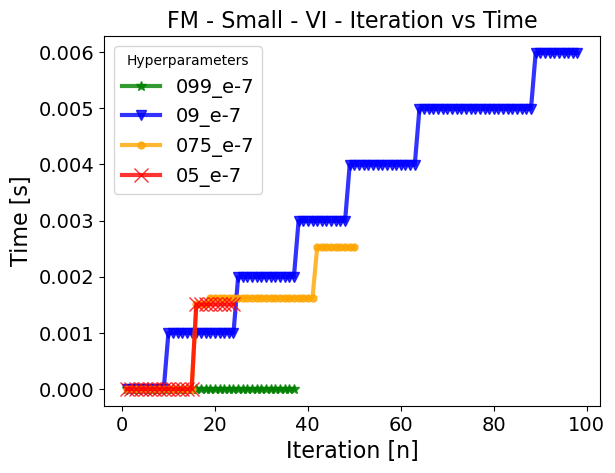

In [211]:
plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Time'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7')
plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Time'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7')
plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Time'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7')
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Time'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')

plt.xlabel("Iteration [n]",fontsize = 16)
plt.ylabel("Time [s]",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FM - Small - VI - Iteration vs Time', size =16)
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})

Text(0.5, 1.0, 'FM - Small - VI - Iterations vs Error')

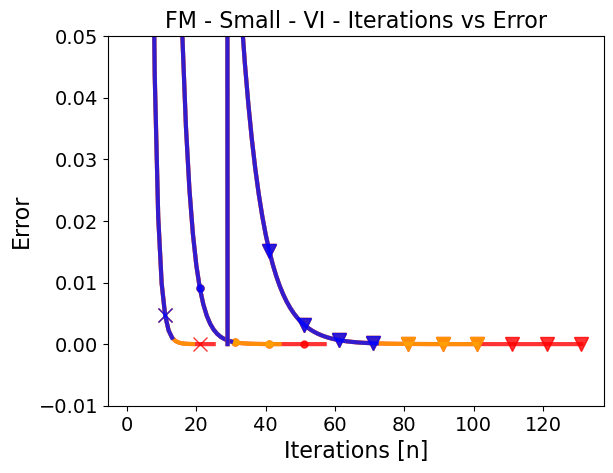

In [297]:
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7',markevery=10)
plt.plot(vi_df_05_e5['Iteration'],vi_df_05_e5['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5',markevery=10)
plt.plot(vi_df_05_e3['Iteration'],vi_df_05_e3['Error'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3',markevery=10)

plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7',markevery=10)
plt.plot(vi_df_075_e5['Iteration'],vi_df_075_e5['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5',markevery=10)
plt.plot(vi_df_075_e3['Iteration'],vi_df_075_e3['Error'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3',markevery=10)

plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Error'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='09_e-7',markevery=10)
plt.plot(vi_df_09_e5['Iteration'],vi_df_09_e5['Error'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5',markevery=10)
plt.plot(vi_df_09_e3['Iteration'],vi_df_09_e3['Error'], 'v-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='09_e-3',markevery=10)

plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Error'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='099_e-7',markevery=10)
plt.plot(vi_df_099_e5['Iteration'],vi_df_099_e5['Error'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5',markevery=10)
plt.plot(vi_df_099_e3['Iteration'],vi_df_099_e3['Error'], '*-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='099_e-3',markevery=10)


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Error",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(-0.01,0.05)
plt.title('FM - Small - VI - Iterations vs Error', size =16)
#plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})

In [333]:
%%time
applied_df_full =pd.DataFrame()
for i in range(0,5):
    applied_df = vi_df.apply(lambda x: evaluate_policy(T,R, x["Policy"]), axis =1)
    applied_df = applied_df.to_frame()
    applied_df = applied_df.rename(columns = {0:'Score_'+str(i)})
    applied_df['Epsilon'] = vi_df['Epsilon']
    applied_df['Discount'] = vi_df['Discount']
    applied_df_full = pd.concat([applied_df_full,applied_df], axis =1)
    
applied_df_full = applied_df_full.loc[:,~applied_df_full.columns.duplicated()].copy()
applied_df_full

,Score_0,Epsilon,Discount,Score_1,Score_2,Score_3,Score_4
0,1049.497238,1.000000e-03,0.50,1034.096579,1067.873478,1094.545933,1138.650996
1,1154.752310,1.000000e-05,0.50,980.706348,1018.029976,1062.112900,1157.979474
2,1045.911006,1.000000e-07,0.50,1050.720282,1117.862279,1008.440618,1149.860219
3,1000.795652,1.000000e-03,0.75,1065.738996,1032.074593,1086.521159,980.318420
4,1129.984710,1.000000e-05,0.75,978.513369,1028.844901,1068.676471,1033.950615
5,1186.551034,1.000000e-07,0.75,1080.347258,1068.975435,1057.141672,1162.137010
6,1103.966212,1.000000e-03,0.90,1108.969613,1044.674450,990.218355,1038.239188
7,1084.290916,1.000000e-05,0.90,1010.326098,1054.047287,984.061479,1019.436587
8,971.262452,1.000000e-07,0.90,1115.692437,1023.760191,983.841627,978.963365
9,1053.900218,1.000000e-03,0.99,1157.123187,1047.905546,1148.676791,1076.408626


In [334]:
applied_df_full['Score_Mean'] = applied_df_full.loc[:, ["Score_0","Score_1","Score_2","Score_3","Score_4"]].mean(axis = 1)
applied_df_full['Score_Std'] = applied_df_full.loc[:, ["Score_0","Score_1","Score_2","Score_3","Score_4"]].std(axis = 1)

In [335]:
applied_df_full

,Score_0,Epsilon,Discount,Score_1,Score_2,Score_3,Score_4,Score_Mean,Score_Std
0,1049.497238,1.000000e-03,0.50,1034.096579,1067.873478,1094.545933,1138.650996,1076.932845,41.197941
1,1154.752310,1.000000e-05,0.50,980.706348,1018.029976,1062.112900,1157.979474,1074.716202,79.919608
2,1045.911006,1.000000e-07,0.50,1050.720282,1117.862279,1008.440618,1149.860219,1074.558881,57.675992
3,1000.795652,1.000000e-03,0.75,1065.738996,1032.074593,1086.521159,980.318420,1033.089764,44.016023
4,1129.984710,1.000000e-05,0.75,978.513369,1028.844901,1068.676471,1033.950615,1047.994013,55.994874
5,1186.551034,1.000000e-07,0.75,1080.347258,1068.975435,1057.141672,1162.137010,1111.030482,59.011274
6,1103.966212,1.000000e-03,0.90,1108.969613,1044.674450,990.218355,1038.239188,1057.213564,49.674222
7,1084.290916,1.000000e-05,0.90,1010.326098,1054.047287,984.061479,1019.436587,1030.432473,39.159406
8,971.262452,1.000000e-07,0.90,1115.692437,1023.760191,983.841627,978.963365,1014.704014,59.995263
9,1053.900218,1.000000e-03,0.99,1157.123187,1047.905546,1148.676791,1076.408626,1096.802873,52.385483


In [337]:
a1 = applied_df_full[applied_df_full['Epsilon']==1.e-07]
a2 = applied_df_full[applied_df_full['Epsilon']==1.e-05]
a3 = applied_df_full[applied_df_full['Epsilon']==1.e-03]

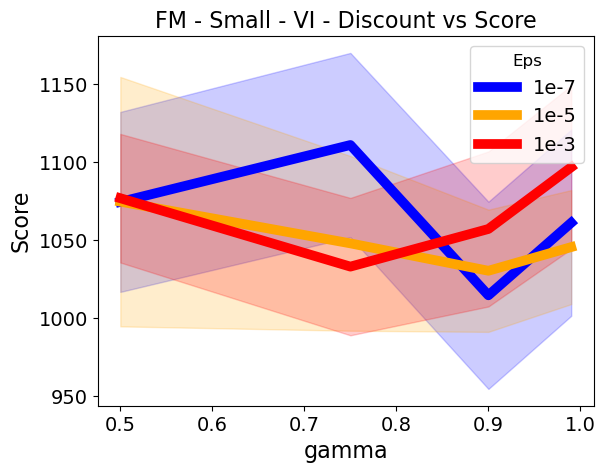

In [338]:
plt.plot(a1['Discount'],a1['Score_Mean'],linewidth =7,color="blue", label='1e-7')
plt.fill_between(a1['Discount'], a1['Score_Mean']+a1['Score_Std'],a1['Score_Mean']-a1['Score_Std'], alpha=0.2, color="blue")


plt.plot(a2['Discount'],a2['Score_Mean'],linewidth =7,color="orange", label='1e-5')
plt.fill_between(a2['Discount'], a2['Score_Mean']+a2['Score_Std'],a2['Score_Mean']-a2['Score_Std'], alpha=0.2, color="orange")

plt.plot(a3['Discount'],a3['Score_Mean'],linewidth =7,color="red", label='1e-3')
plt.fill_between(a3['Discount'], a3['Score_Mean']+a3['Score_Std'],a3['Score_Mean']-a3['Score_Std'], alpha=0.2, color="red")


plt.xlabel('gamma',fontsize = 16)
plt.ylabel('Score',fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(75,85)
plt.title('FM - Small - VI - Discount vs Score', fontsize=16)
# plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.legend(title="Eps",title_fontsize=12, loc="best",prop={'size': 14})

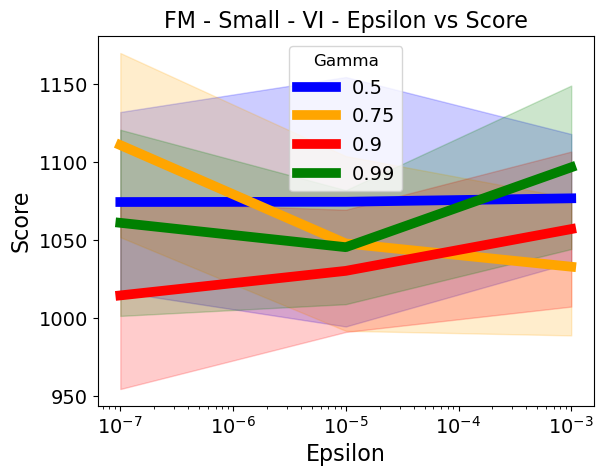

In [339]:
b1 = applied_df_full[applied_df_full['Discount']==0.5]
b2 = applied_df_full[applied_df_full['Discount']==0.75]
b3 = applied_df_full[applied_df_full['Discount']==0.9]
b4 = applied_df_full[applied_df_full['Discount']==0.99]


plt.plot(b1['Epsilon'],b1['Score_Mean'],linewidth =7,color="blue", label='0.5')
plt.fill_between(b1['Epsilon'], b1['Score_Mean']+b1['Score_Std'],b1['Score_Mean']-b1['Score_Std'], alpha=0.2, color="blue")


plt.plot(b2['Epsilon'],b2['Score_Mean'],linewidth =7,color="orange", label='0.75')
plt.fill_between(b2['Epsilon'], b2['Score_Mean']+b2['Score_Std'],b2['Score_Mean']-b2['Score_Std'], alpha=0.2, color="orange")

plt.plot(b3['Epsilon'],b3['Score_Mean'],linewidth =7,color="red", label='0.9')
plt.fill_between(b3['Epsilon'], b3['Score_Mean']+b3['Score_Std'],b3['Score_Mean']-b3['Score_Std'], alpha=0.2, color="red")

plt.plot(b4['Epsilon'],b4['Score_Mean'],linewidth =7,color="green", label='0.99')
plt.fill_between(b4['Epsilon'], b4['Score_Mean']+b4['Score_Std'],b4['Score_Mean']-b4['Score_Std'], alpha=0.2, color="green")


plt.xlabel('Epsilon',fontsize = 16)
plt.ylabel('Score',fontsize = 16)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(75,85)
plt.title('FM - Small - VI - Epsilon vs Score', fontsize=16)
plt.legend(title="Gamma",title_fontsize=12, loc="best",prop={'size': 14})

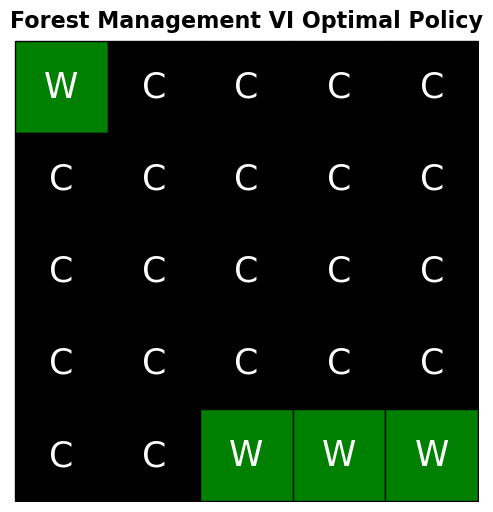

In [352]:
#bestRun = vi_df['Reward'].argmax()
#bestRun = vi_df.loc[19]['Policy']
bestPolicy =  vi_df.loc[2]['Policy']

title='Forest Management VI Optimal Policy'
plot_forest(bestPolicy, title)